# Credit Risk — EDA y Baseline

Este notebook carga el dataset, realiza una EDA rápida y entrena un baseline (Logistic Regression y LightGBM) con métricas ROC-AUC.

In [25]:
# %% Imports
import os, sys, math, json, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, precision_recall_curve, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")
import os

## 1) Carga de datos

In [8]:
# Ruta relativa al proyecto
path = os.path.join("..", "data", "raw", "credit_risk_dataset.csv")
df = pd.read_csv(path)

print(f"✅ Dataset cargado desde: {os.path.abspath(path)}")
print("Shape:", df.shape)
df.head()

✅ Dataset cargado desde: c:\Users\wladi\Desktop\Data Science\Portafolio\credit_risk\data\raw\credit_risk_dataset.csv
Shape: (32581, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


## 2) Inspección rápida

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


la columna loan_int_rate y person_emp_length estan incompletas

In [10]:
df.describe(include='all').T.head(15)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
person_age,32581.0,NaN,NaN,NaN,27.7346,6.348078,20.0,23.0,26.0,30.0,144.0
person_income,32581.0,NaN,NaN,NaN,66074.84847,61983.119168,4000.0,38500.0,55000.0,79200.0,6000000.0
person_home_ownership,32581,4,RENT,16446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
person_emp_length,31686.0,NaN,NaN,NaN,4.789686,4.14263,0.0,2.0,4.0,7.0,123.0
loan_intent,32581,6,EDUCATION,6453,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_grade,32581,7,A,10777,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,32581.0,NaN,NaN,NaN,9589.371106,6322.086646,500.0,5000.0,8000.0,12200.0,35000.0
loan_int_rate,29465.0,NaN,NaN,NaN,11.011695,3.240459,5.42,7.9,10.99,13.47,23.22
loan_status,32581.0,NaN,NaN,NaN,0.218164,0.413006,0.0,0.0,0.0,0.0,1.0
loan_percent_income,32581.0,NaN,NaN,NaN,0.170203,0.106782,0.0,0.09,0.15,0.23,0.83


## 2.1) Inspección valores numéricos

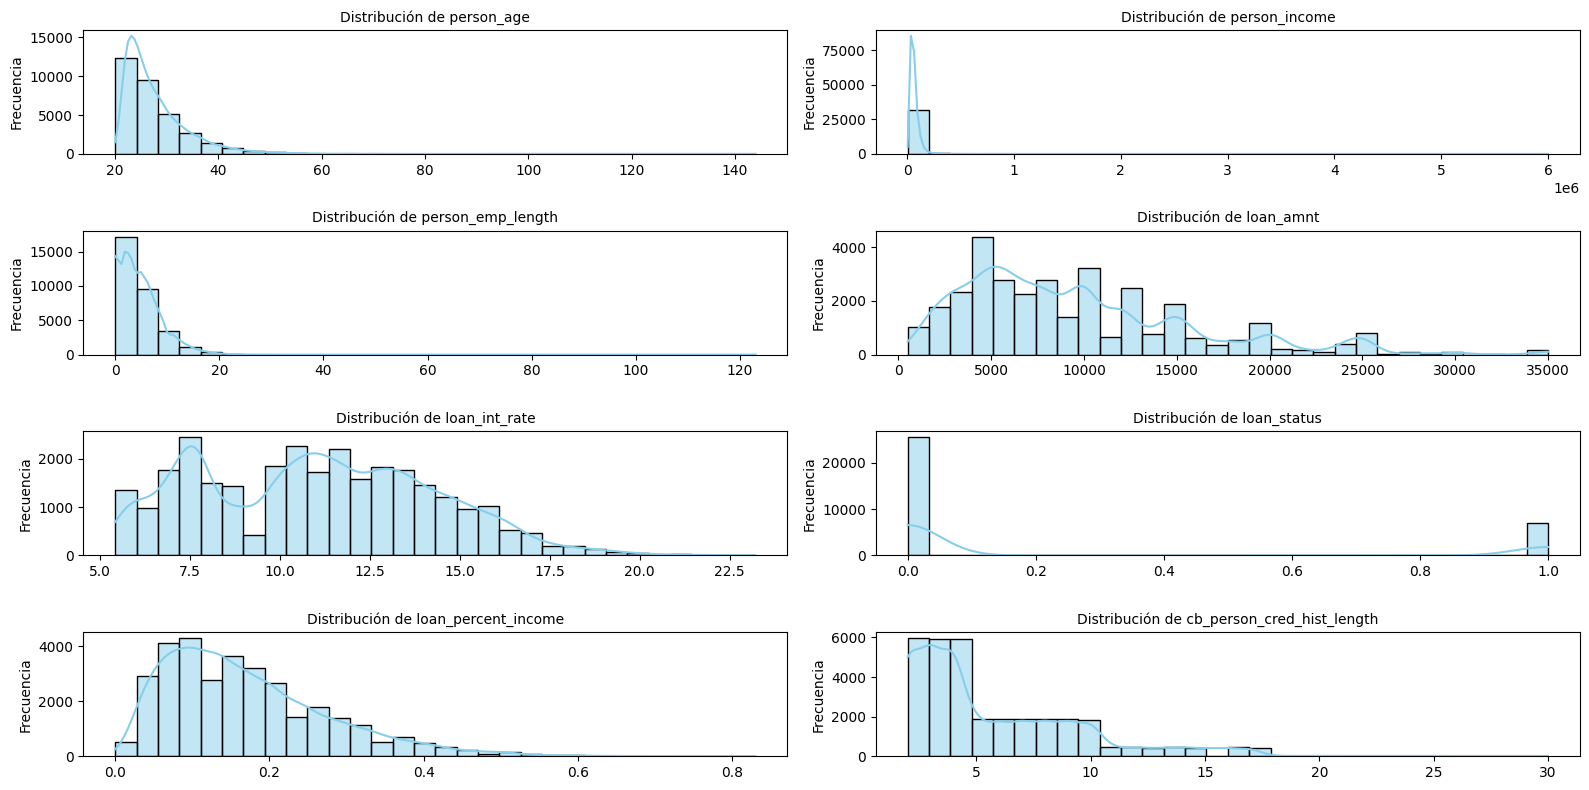

In [29]:
# Seleccionamos solo las columnas numéricas
num_cols = df.select_dtypes(include=['number']).columns

n_cols = 2
n_rows = math.ceil(len(num_cols) / n_cols)

# Ajustamos la figura general
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 2))
axes = axes.flatten()

# Dibujamos cada histograma
for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, bins=30, color='skyblue', ax=axes[i])
    axes[i].set_title(f"Distribución de {col}", fontsize=10)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frecuencia")

# Quitamos ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

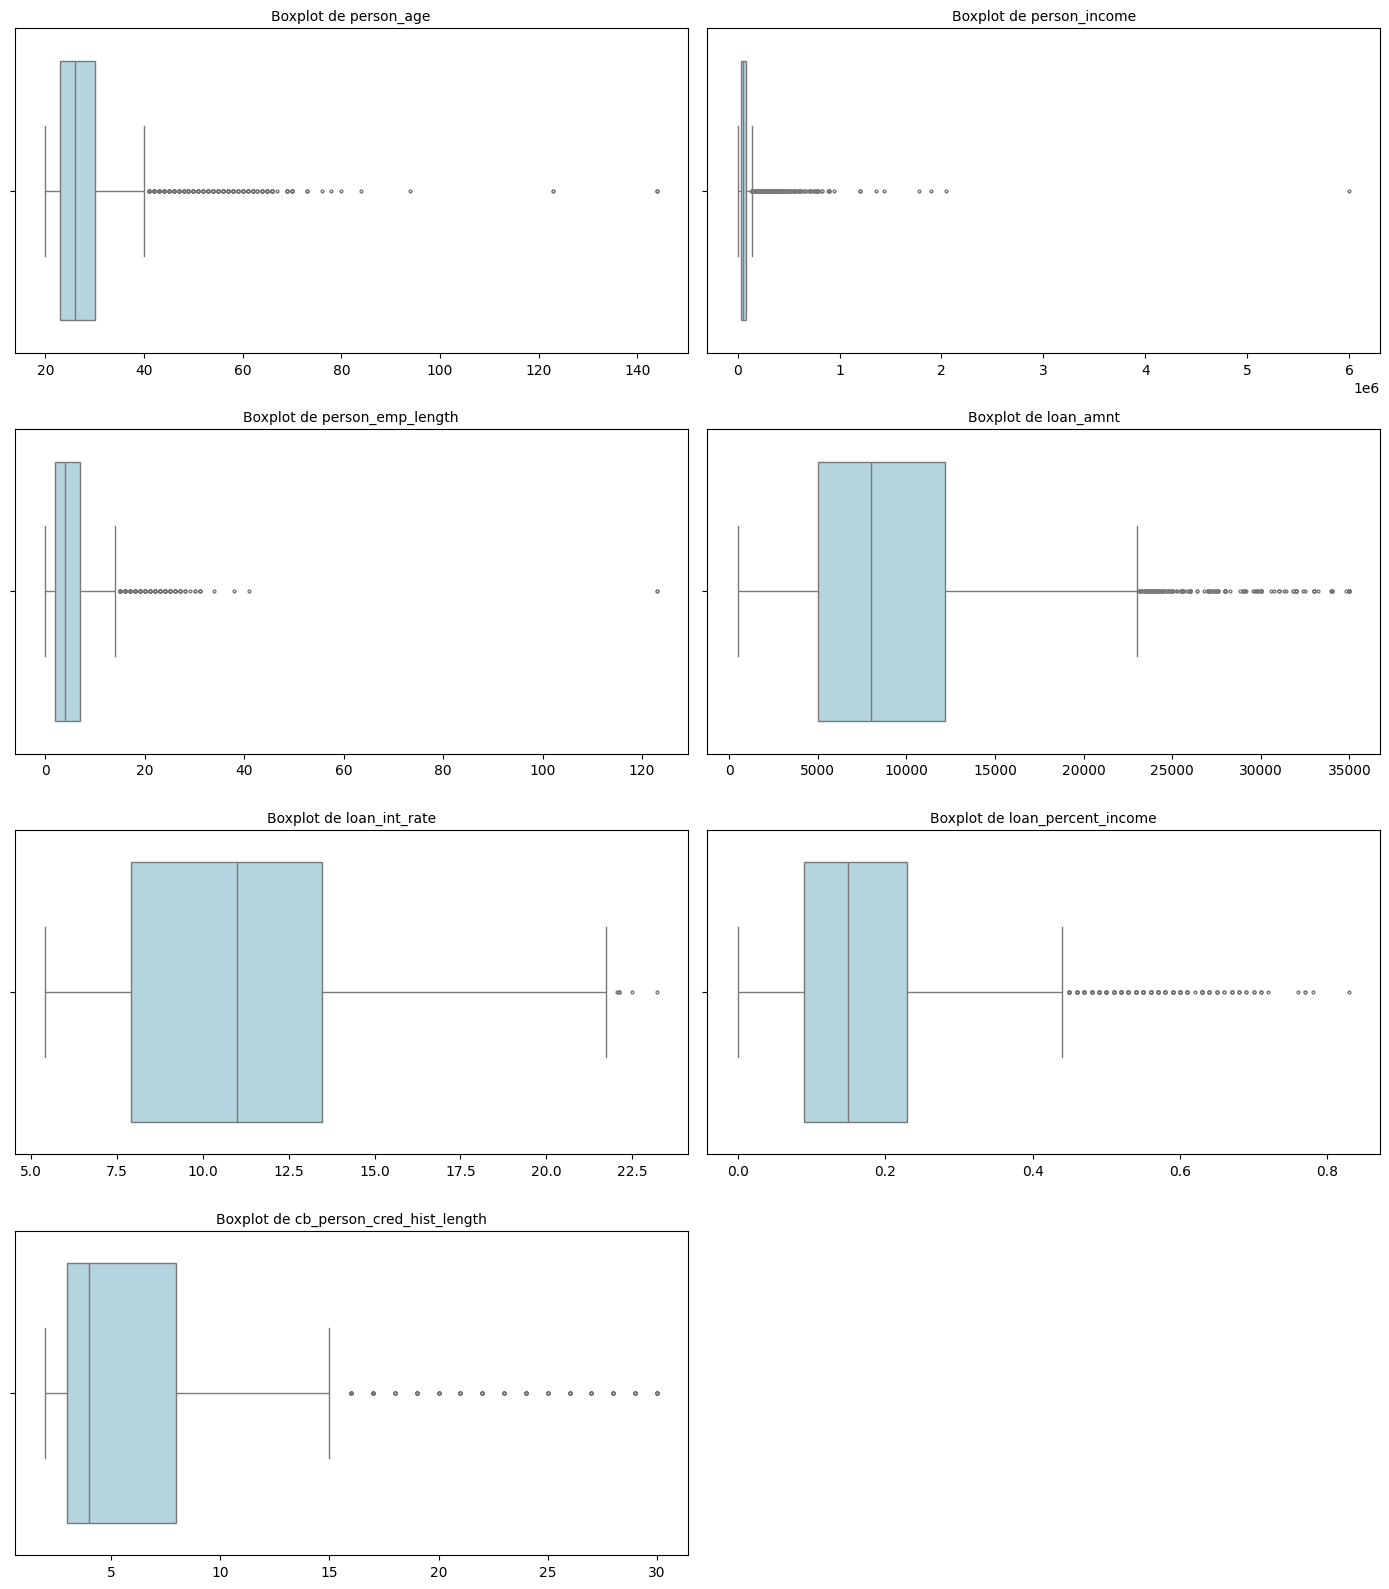

In [32]:
# Seleccionamos solo las columnas numéricas (sin incluir el target)
num_cols = [col for col in df.select_dtypes(include=['number']).columns if col != 'loan_status']

# Configuración de cuadrícula
n_cols = 2
n_rows = math.ceil(len(num_cols) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))
axes = axes.flatten()

# Creamos un boxplot por variable
for i, col in enumerate(num_cols):
    sns.boxplot(x=df[col], ax=axes[i], color='lightblue', fliersize=2)
    axes[i].set_title(f"Boxplot de {col}", fontsize=10)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Eliminamos ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [33]:
# Contar valores sospechosos
cond_age = df["person_age"] > 100
cond_emp = df["person_emp_length"] > 50
cond_income = df["person_income"] > df["person_income"].quantile(0.99)

print("Registros con edad > 100:", cond_age.sum())
print("Registros con emp_length > 50:", cond_emp.sum())
print("Registros con income > p99:", cond_income.sum())


Registros con edad > 100: 5
Registros con emp_length > 50: 2
Registros con income > p99: 326


## 2.2) Valores numéricos atípicos

In [35]:
# 1️⃣ Eliminamos registros con edad y emp_length sospechosos
df = df[(df["person_age"] <= 100) & 
        (df["person_emp_length"] <= 50)]

# 2️⃣ Recortamos outliers de ingreso (winsorización al 1% y 99%)
p01, p99 = df["person_income"].quantile([0.01, 0.99])
df["person_income"] = df["person_income"].clip(p01, p99)

# 3️⃣ Verificamos resultado
print("Shape después de limpieza:", df.shape)
print("Edad máxima:", df["person_age"].max())
print("Emp length máximo:", df["person_emp_length"].max())
print("Ingreso máximo:", df["person_income"].max())

Shape después de limpieza: (31679, 12)
Edad máxima: 94
Emp length máximo: 41.0
Ingreso máximo: 227610


## 2.3) Inspeción valores categóricos

Columnas categóricas: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


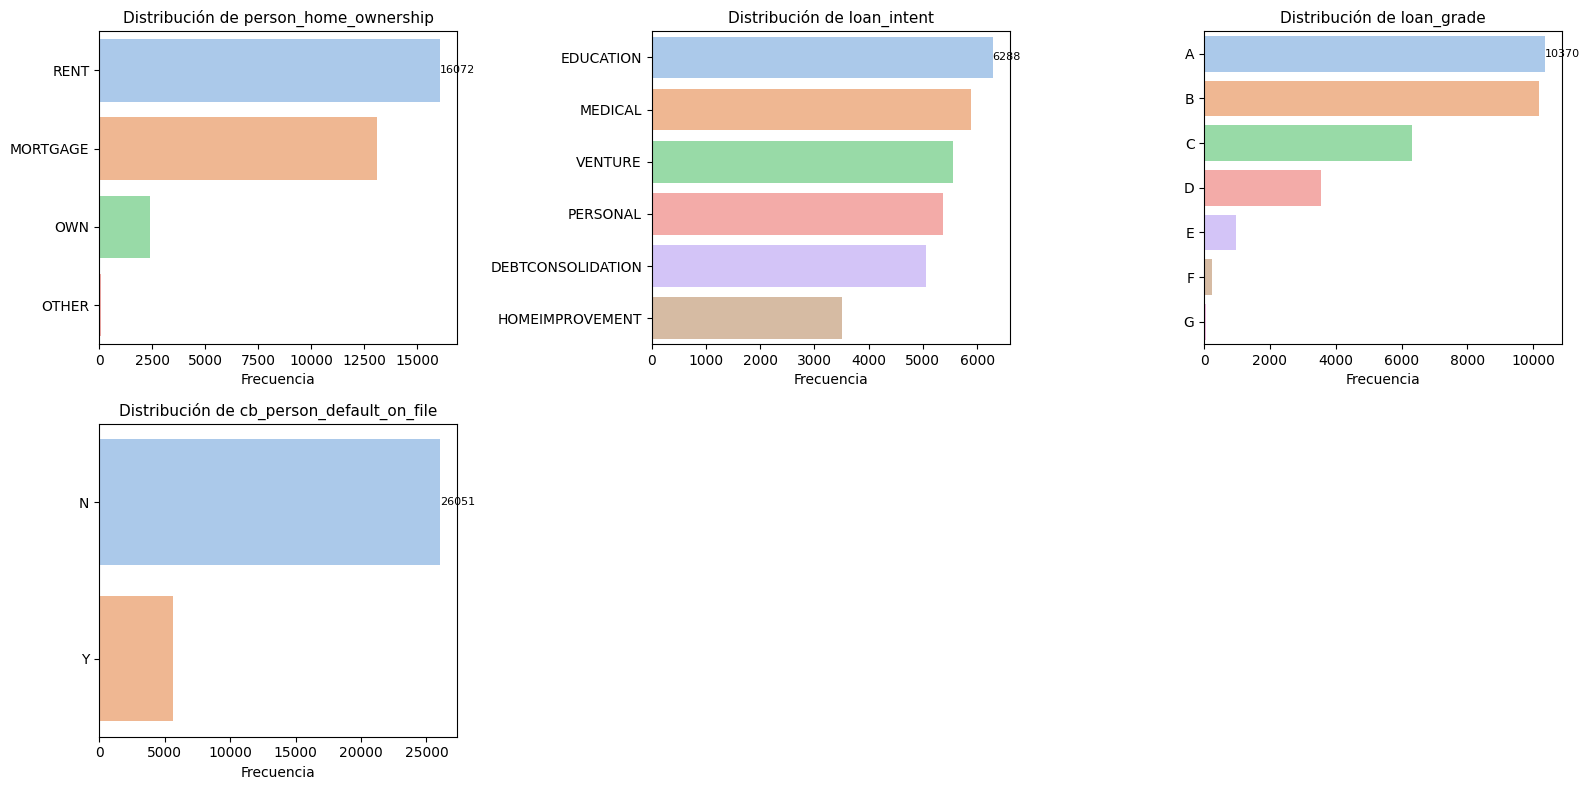

In [36]:
# identificamos columnas categóricas
cat_cols = df.select_dtypes(include=['object']).columns
print(f"Columnas categóricas: {list(cat_cols)}")

# configuramos cuadrícula
n_cols = 3
n_rows = math.ceil(len(cat_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

# un gráfico de barras por variable categórica
for i, col in enumerate(cat_cols):
    sns.countplot(y=df[col], order=df[col].value_counts().index, ax=axes[i], palette="pastel")
    axes[i].set_title(f"Distribución de {col}", fontsize=11)
    axes[i].set_xlabel("Frecuencia")
    axes[i].set_ylabel("")
    axes[i].bar_label(axes[i].containers[0], fmt='%d', label_type='edge', fontsize=8)

# eliminamos ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Agrupar valores que se encuentran debajo del 2%
Esto para que al momento de modelar no se tomarían en cuenta, se debe tener cuidado en el caso que dichos casos especiales tengan importancia para el modelo o influyan en la variable objetivo.

In [37]:
# Agrupar loan_grade (E, F, G → LOW_GRADE)
df["loan_grade"] = df["loan_grade"].replace({"E": "LOW_GRADE", "F": "LOW_GRADE", "G": "LOW_GRADE"})

# Agrupar home_ownership (OTHER → OWN)
df["person_home_ownership"] = df["person_home_ownership"].replace({"OTHER": "OWN"})

# Verificar resultados
print(df["loan_grade"].value_counts())
print(df["person_home_ownership"].value_counts())


loan_grade
A            10370
B            10183
C             6319
D             3555
LOW_GRADE     1252
Name: count, dtype: int64
person_home_ownership
RENT        16072
MORTGAGE    13090
OWN          2517
Name: count, dtype: int64


In [39]:
grade_order = {'A':1, 'B':2, 'C':3, 'D':4, 'LOW_GRADE':5}
df["loan_grade_ord"] = df["loan_grade"].map(grade_order)
df[["loan_grade", "loan_grade_ord"]].head()

,loan_grade,loan_grade_ord
1,B,2
2,C,3
3,C,3
4,C,3
5,A,1


## 3) Variable objetivo

In [ ]:
target = "loan_status" 
dist = df[target].value_counts(dropna=False)
ratio = df[target].value_counts(normalize=True).round(4)
pd.DataFrame({"count": dist, "ratio": ratio})

,count,ratio
loan_status,,
0,25473,0.7818
1,7108,0.2182


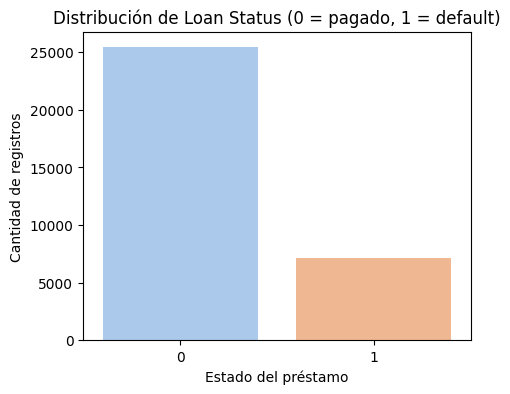

In [22]:
# Configuración base
plt.figure(figsize=(5,4))
sns.countplot(x="loan_status", data=df, palette="pastel")
plt.title("Distribución de Loan Status (0 = pagado, 1 = default)")
plt.xlabel("Estado del préstamo")
plt.ylabel("Cantidad de registros")
plt.show()

## 4) Análisis Multivariable

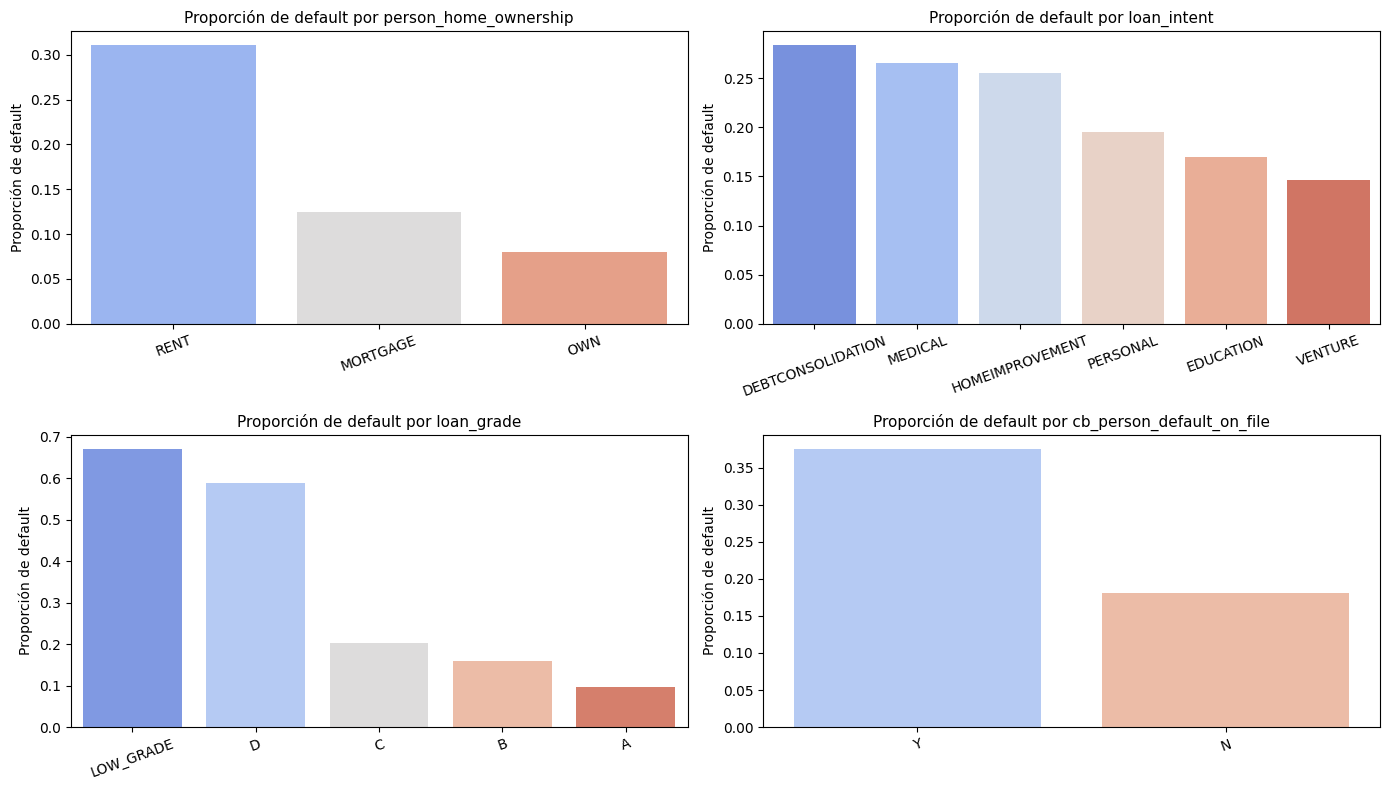

In [ ]:
cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

fig, axes = plt.subplots(2, 2, figsize=(14,8))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    prop = (
        df.groupby(col)['loan_status']
          .mean()
          .sort_values(ascending=False)
          .reset_index()
    )
    sns.barplot(x=col, y='loan_status', data=prop, palette='coolwarm', ax=axes[i])
    axes[i].set_title(f'Proporción de default por {col}', fontsize=11)
    axes[i].set_ylabel('Proporción de default')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.show()

**person_home_ownership:** Los inquilinos (RENT) son los más propensos a incumplir (~30%), mientras que los propietarios (OWN) tienen el menor riesgo (~8%).

**loan_intent:** Los préstamos destinados a consolidar deudas o gastos médicos presentan mayor proporción de default, mientras que los de educación y emprendimientos son más estables.

**loan_grade:** La probabilidad de default aumenta conforme disminuye la calificación. Los créditos LOW_GRADE concentran casi el 70% de impagos.

**cb_person_default_on_file:** Tener historial de impago (“Y”) duplica el riesgo de default en comparación con quienes no lo tienen (“N”).

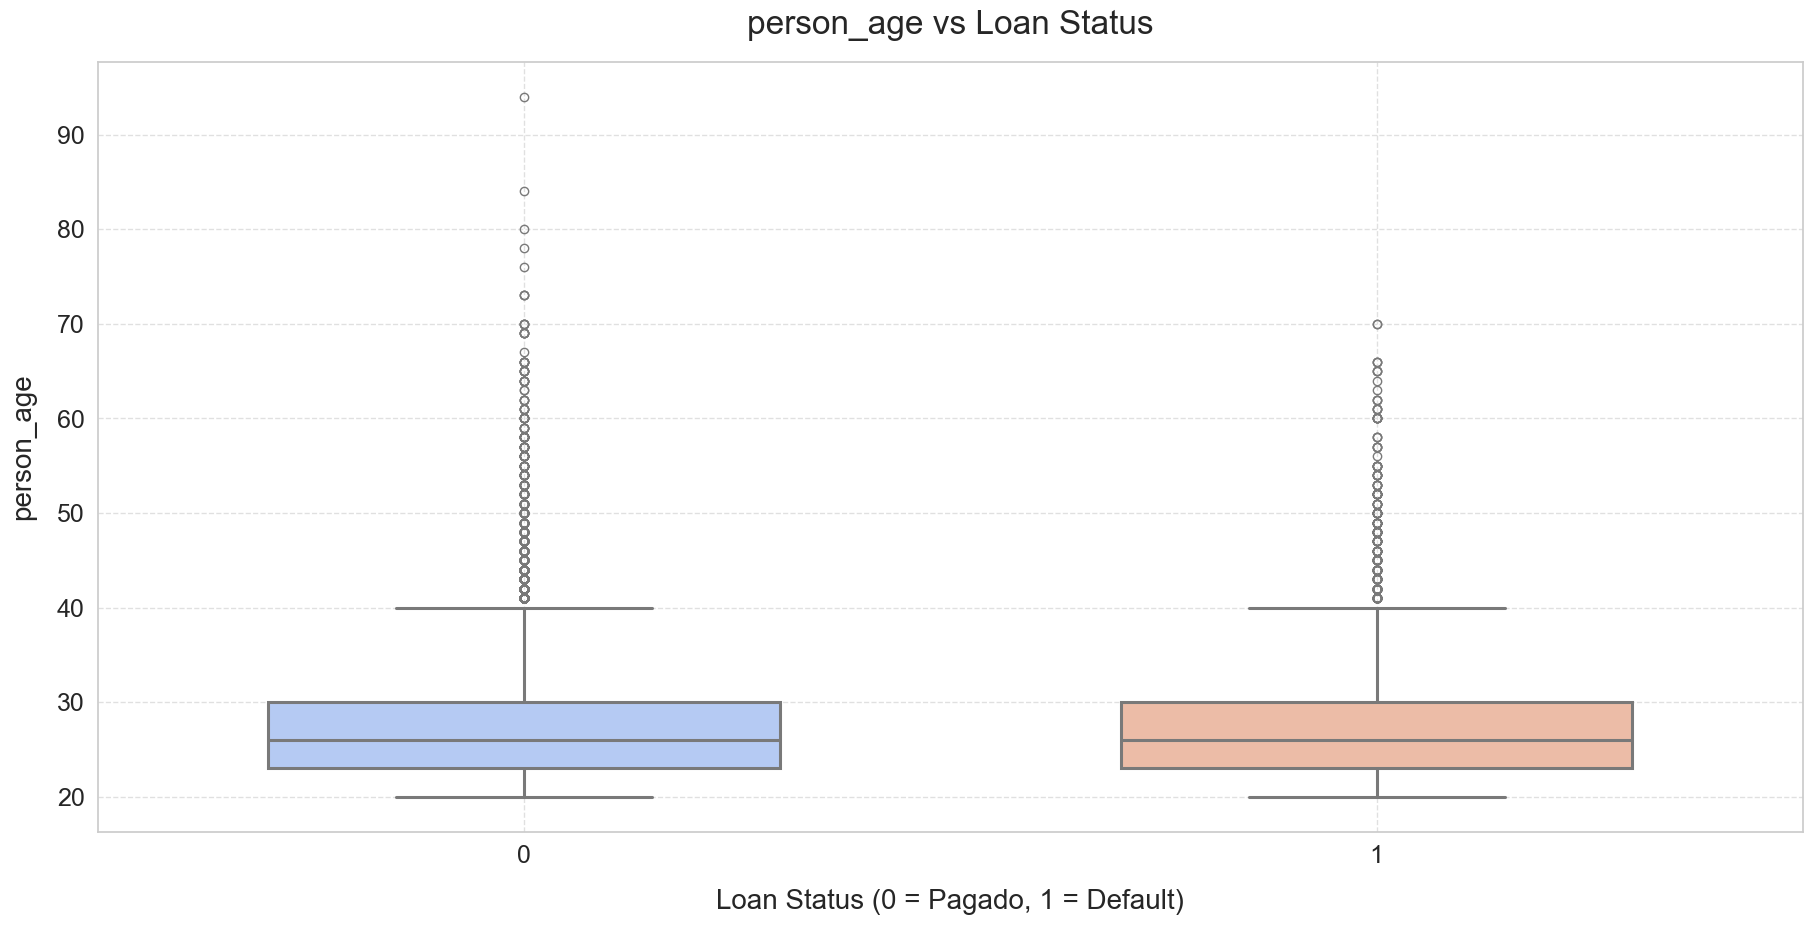

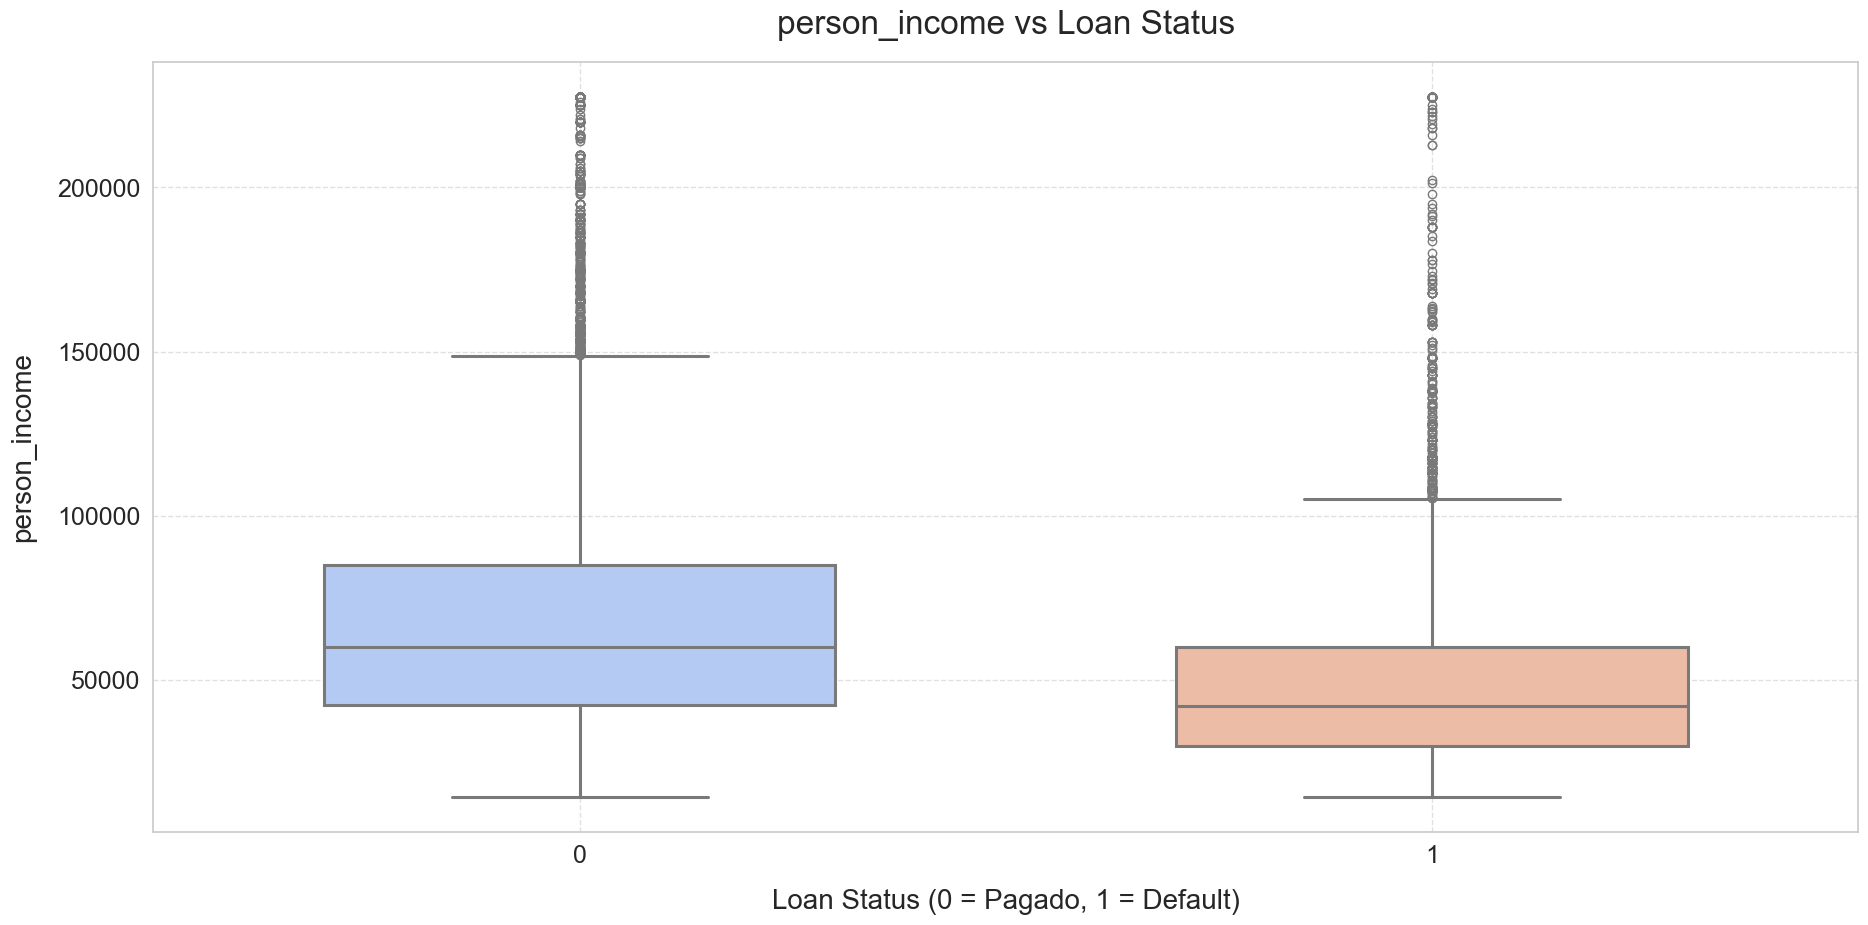

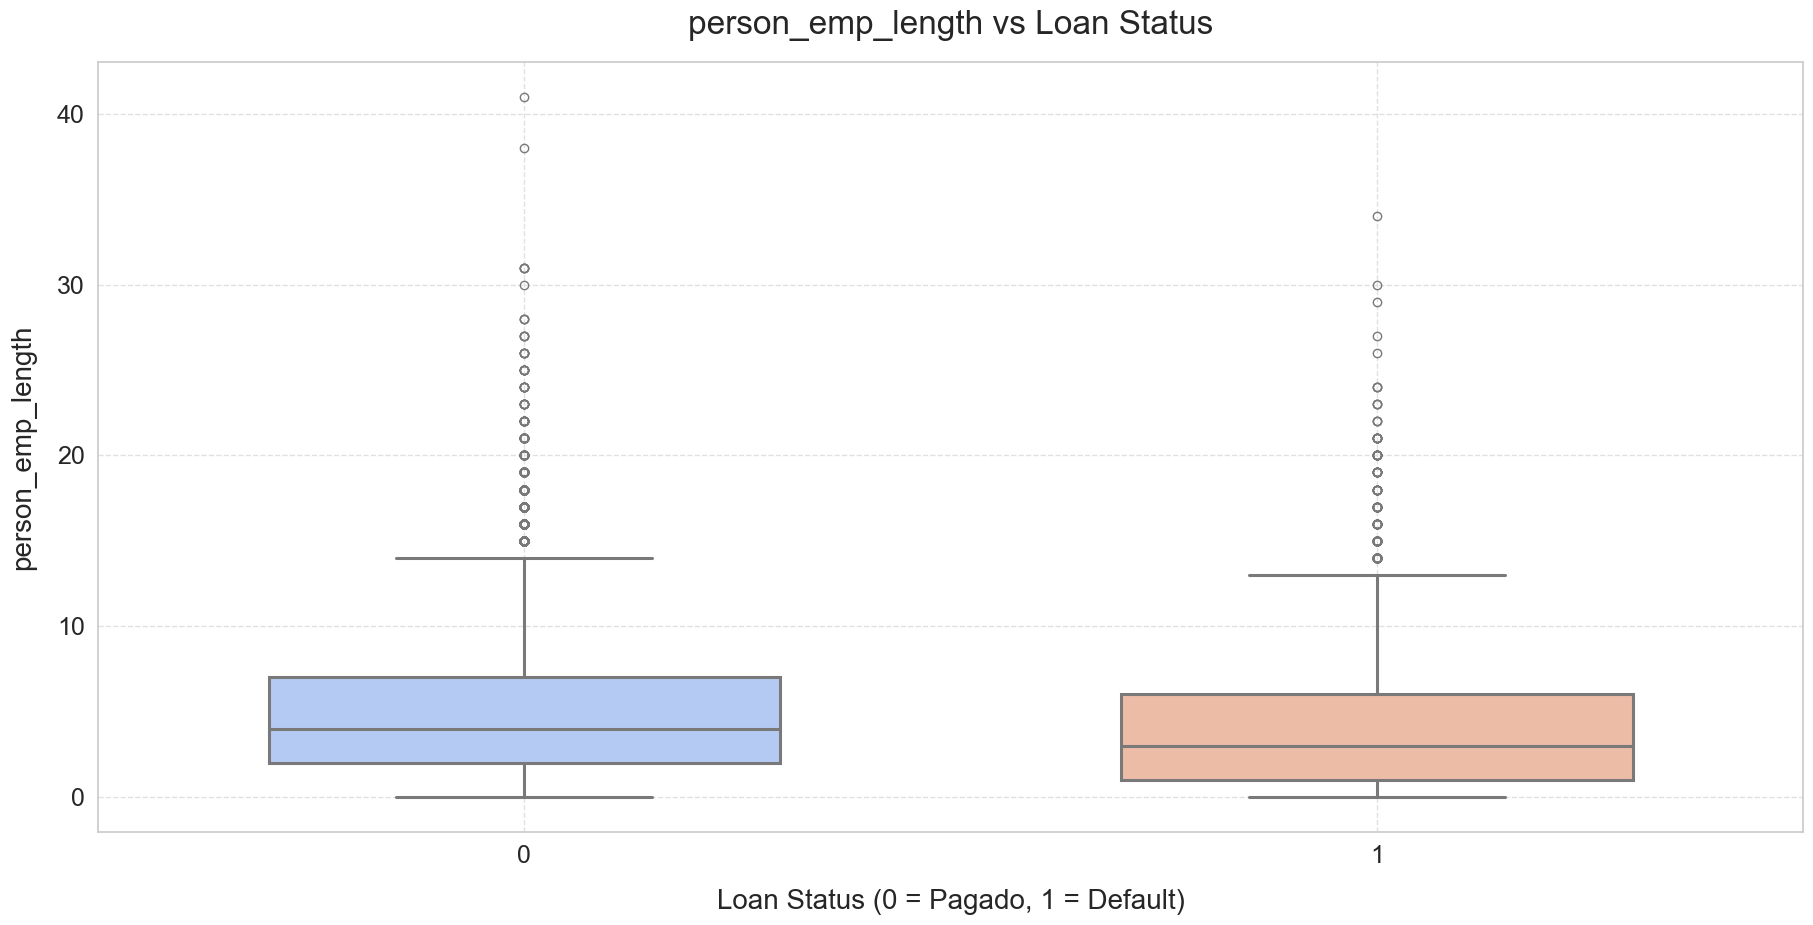

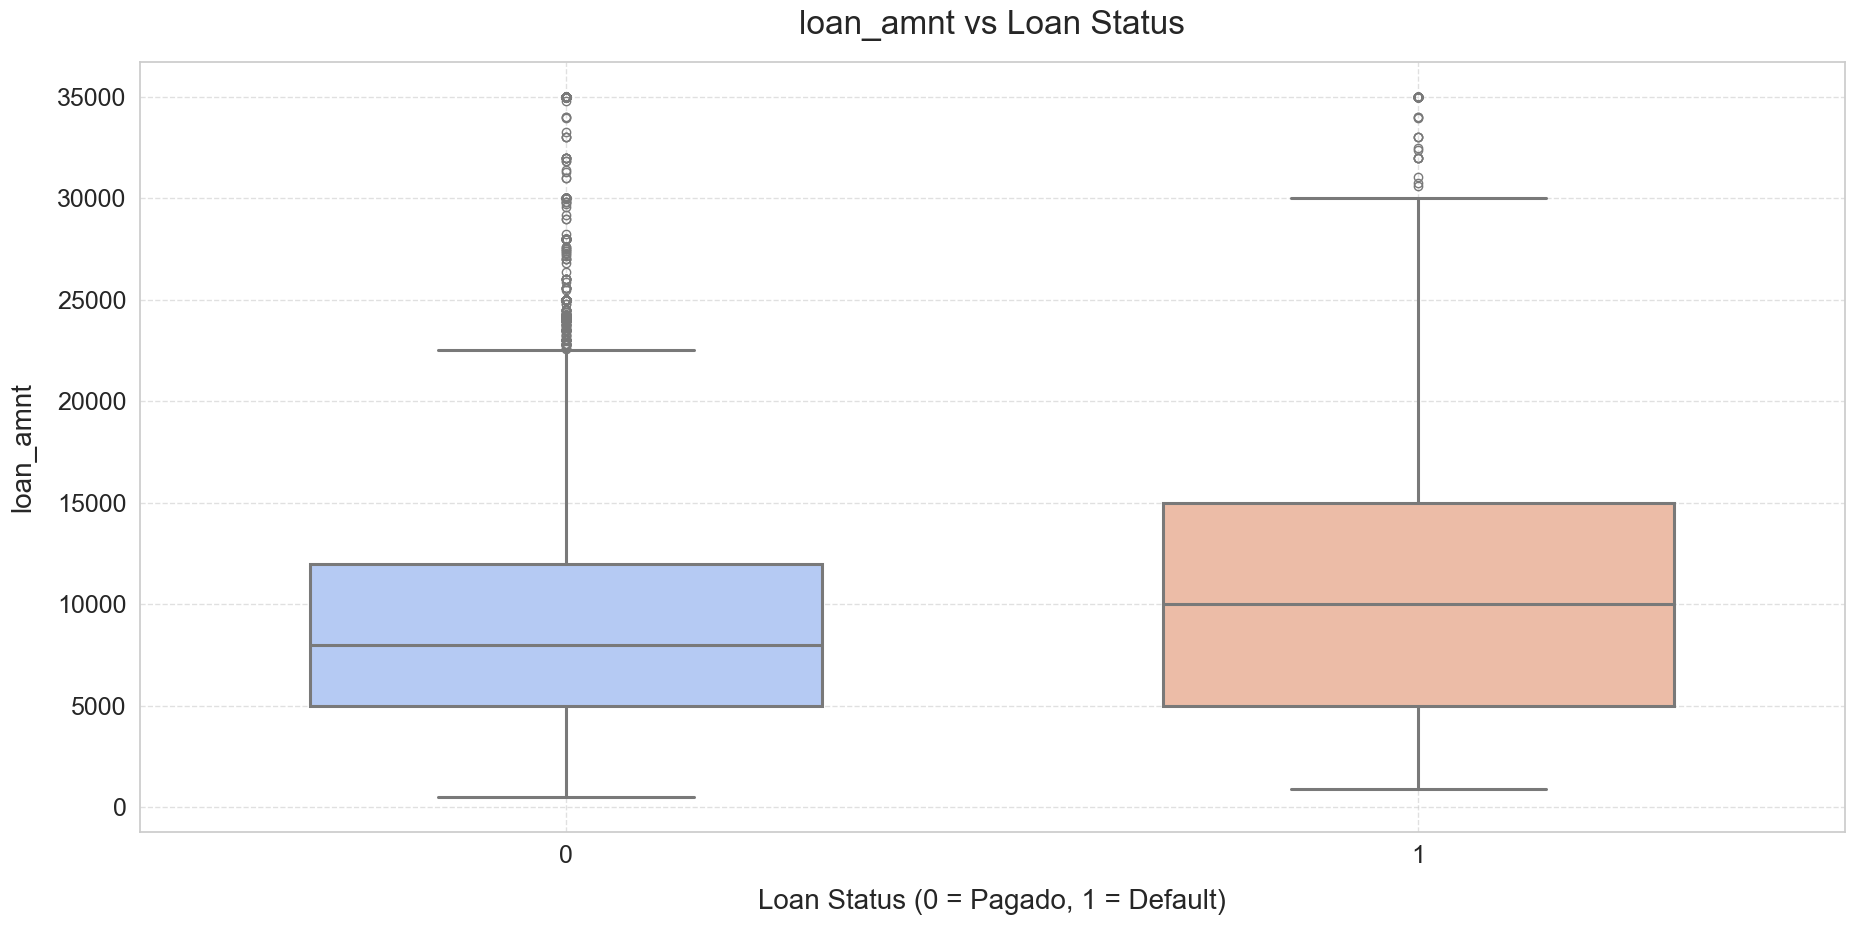

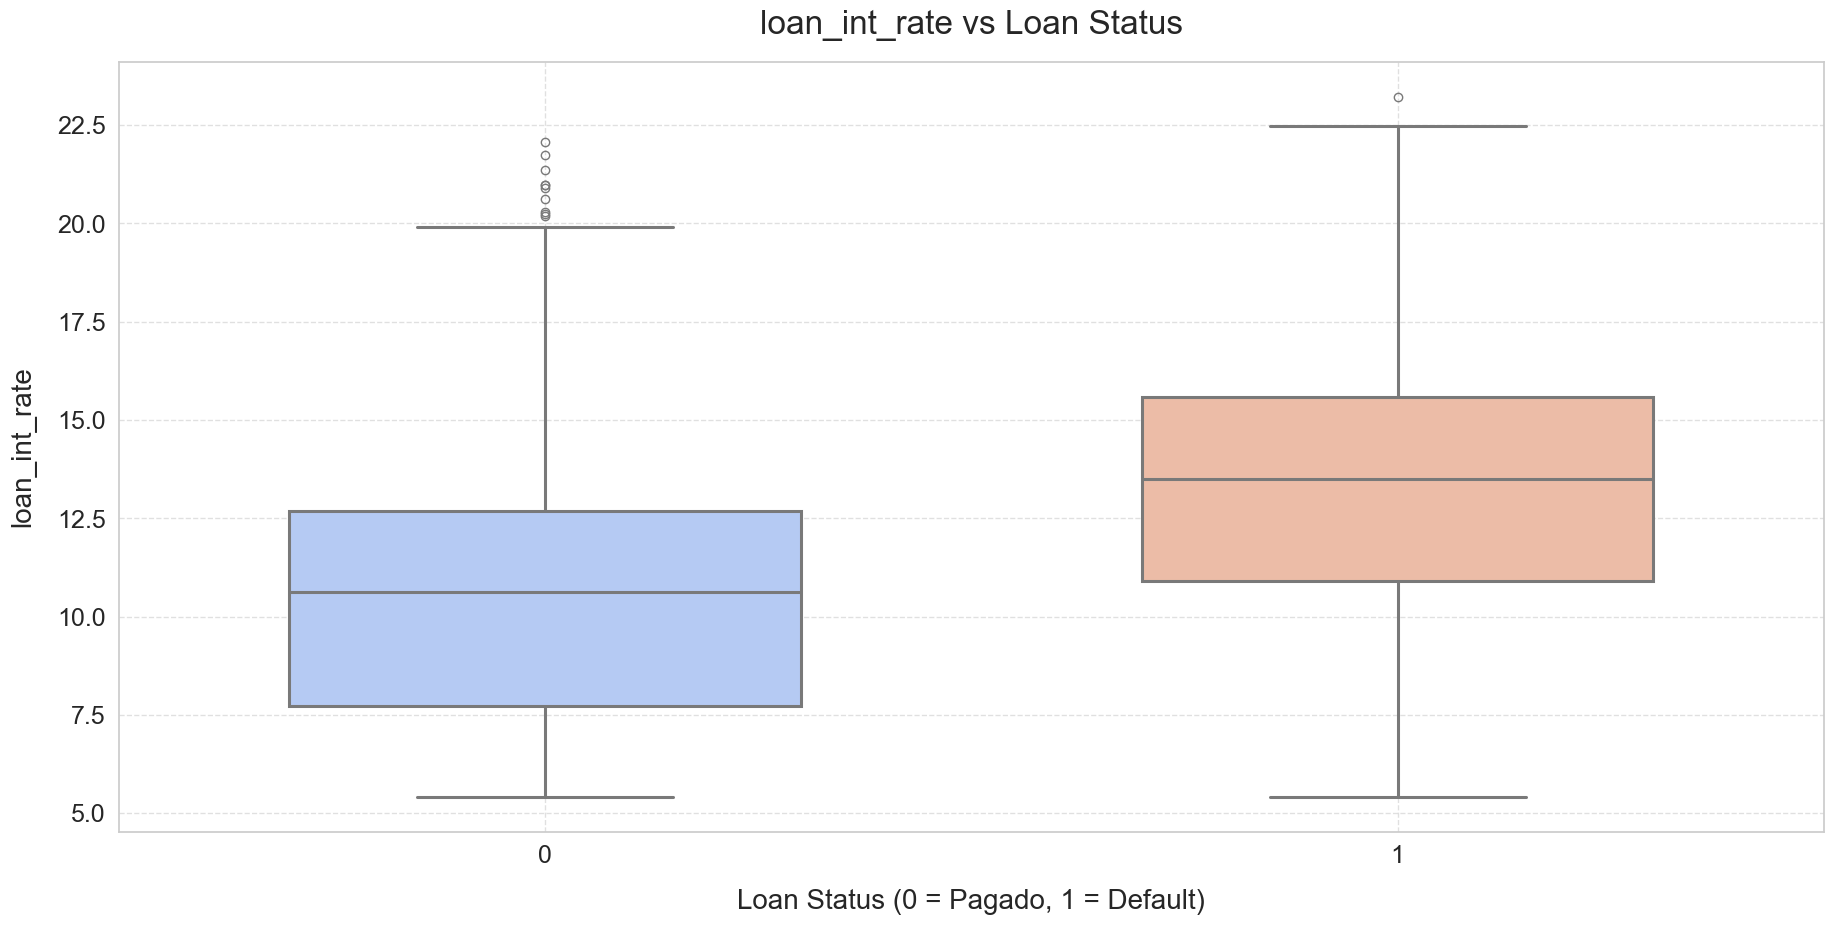

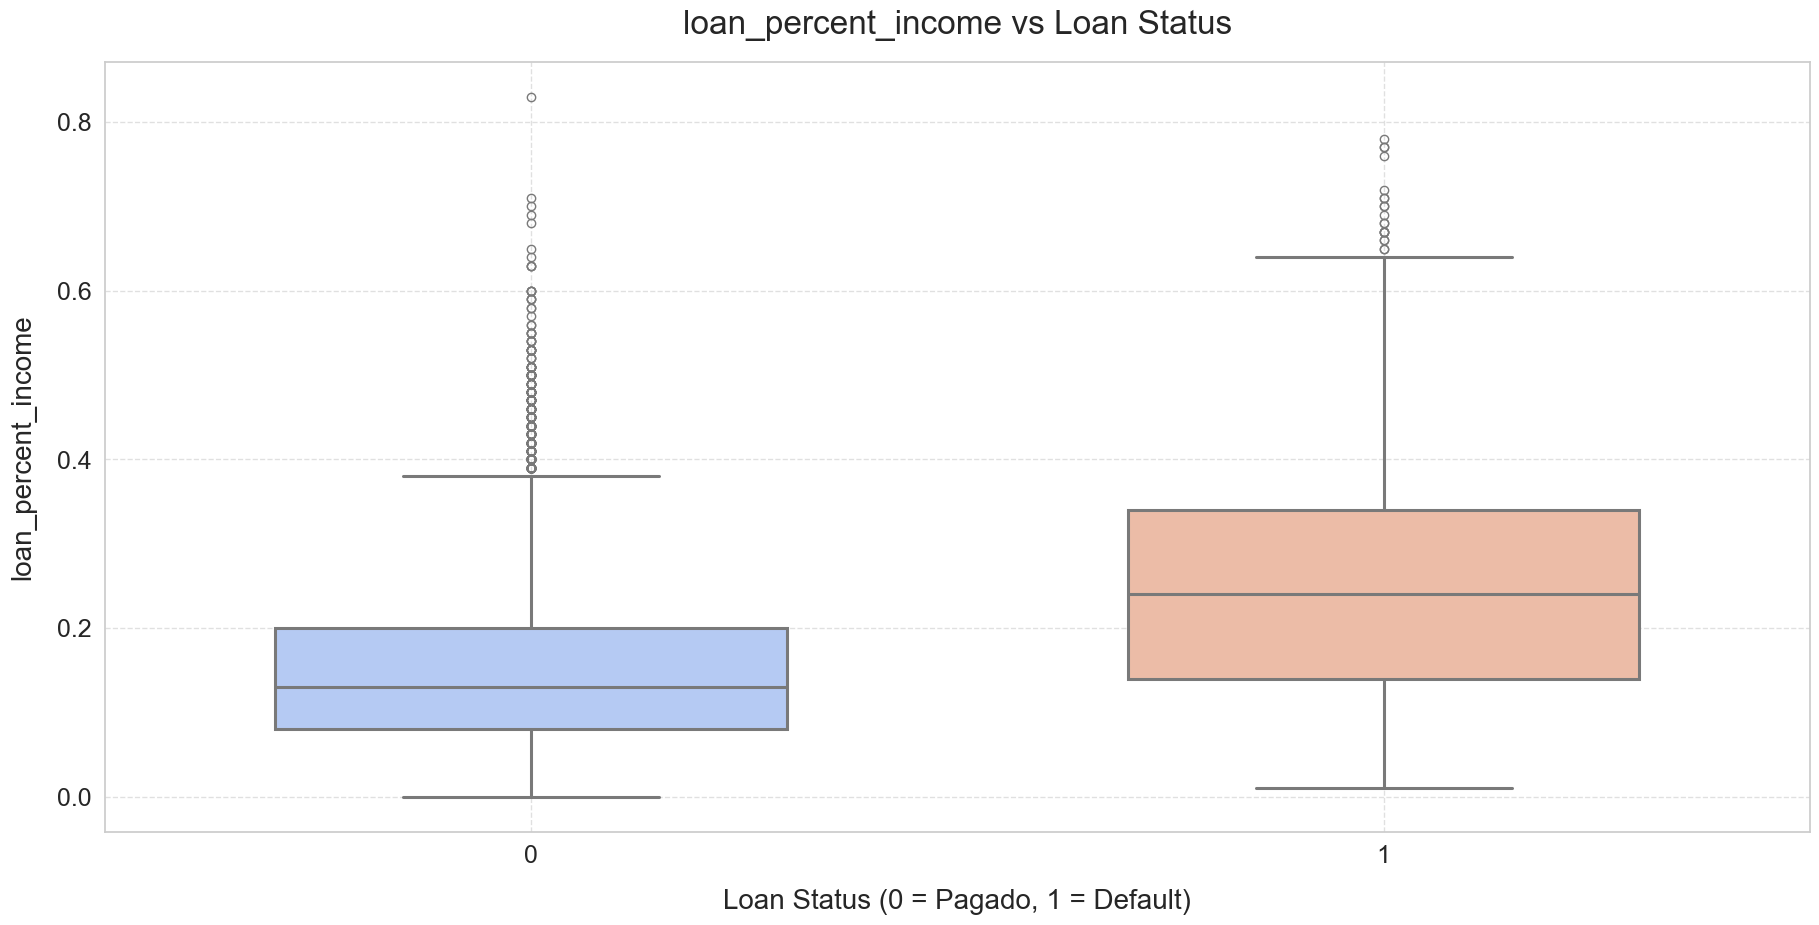

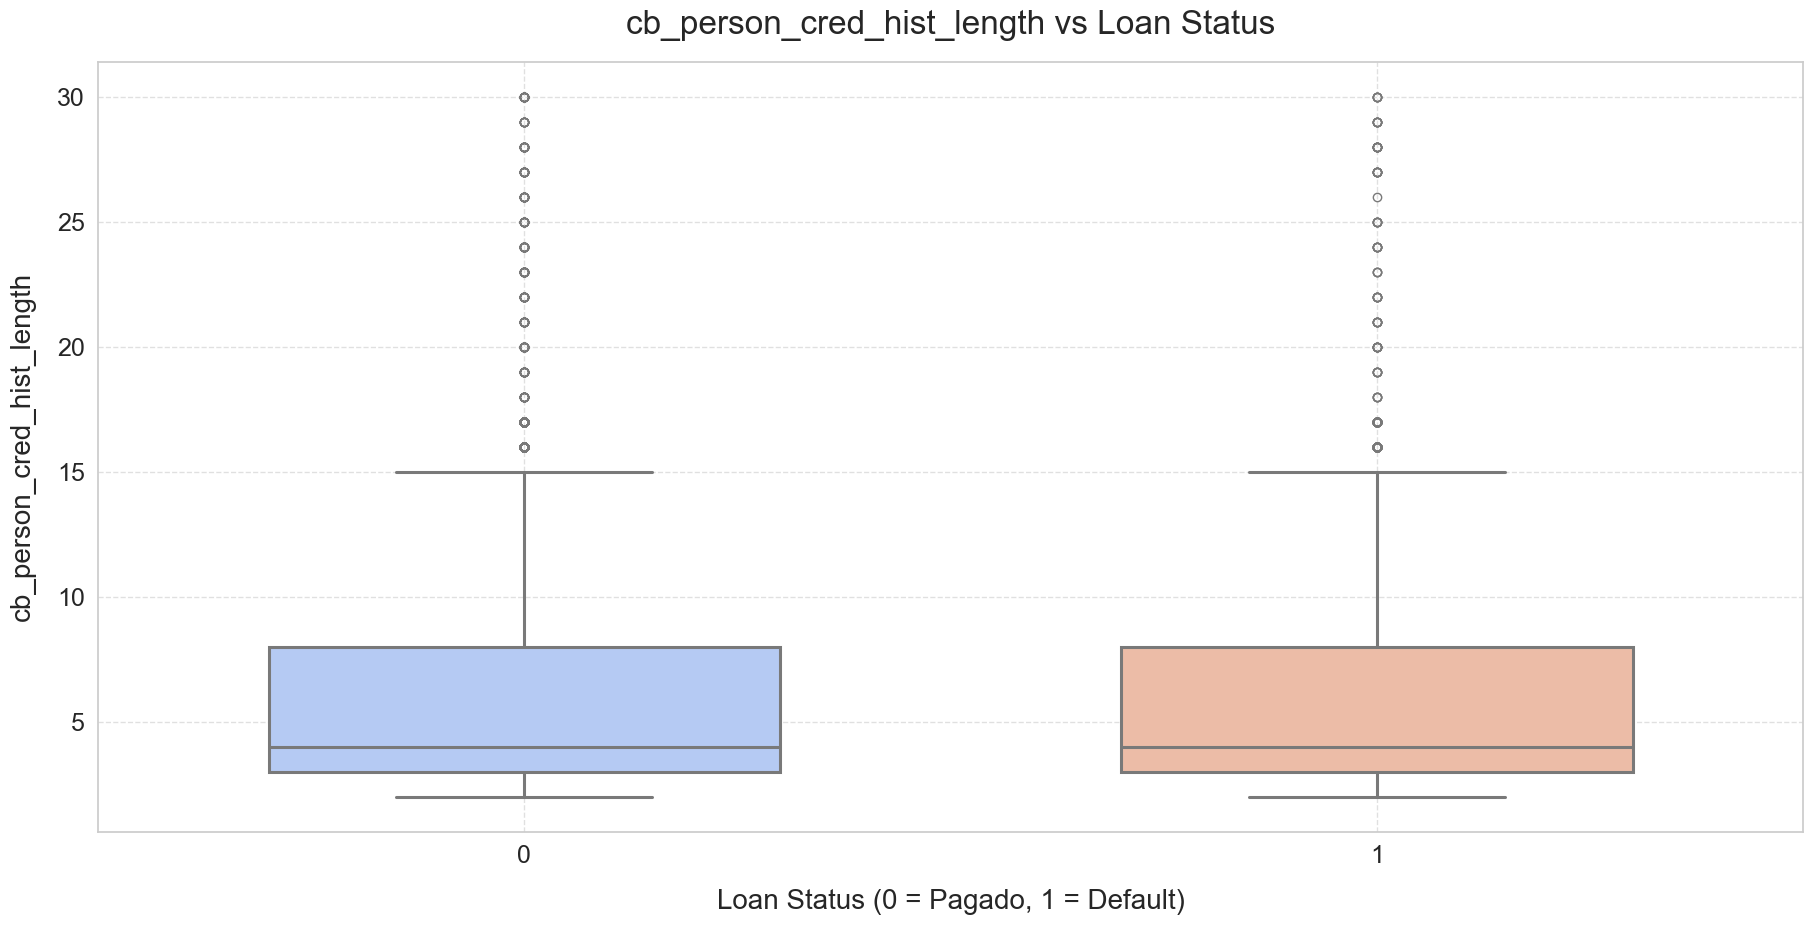

In [49]:
# Variables numéricas
num_cols = [
    'person_age', 'person_income', 'person_emp_length',
    'loan_amnt', 'loan_int_rate', 'loan_percent_income',
    'cb_person_cred_hist_length'
]

# Estilo visual
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "font.size": 18,
    "axes.titlesize": 24,
    "axes.labelsize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "figure.facecolor": "white"
})

# Loop para graficar cada variable de manera individual
for col in num_cols:
    plt.figure(figsize=(22, 10))  # 📏 cada gráfico ocupa toda la ventana
    sns.boxplot(
        data=df,
        x='loan_status', y=col,
        palette='coolwarm',
        linewidth=2.2, fliersize=6, width=0.6
    )
    plt.title(f'{col} vs Loan Status', pad=20)
    plt.xlabel('Loan Status (0 = Pagado, 1 = Default)', labelpad=15)
    plt.ylabel(col, labelpad=15)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


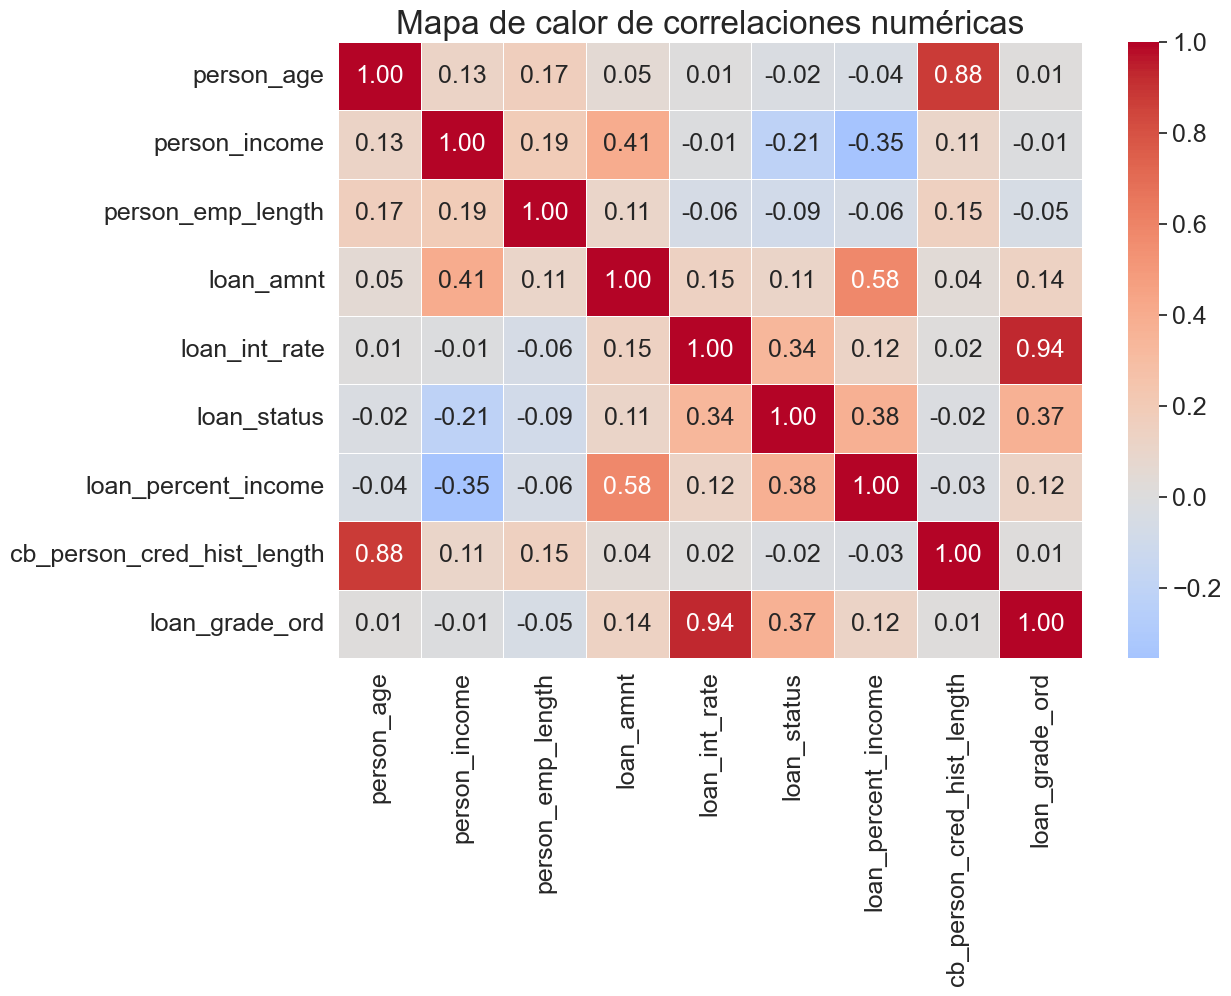

In [50]:
# Calcular correlaciones (Pearson)
corr = df.corr(numeric_only=True, method='pearson')

plt.figure(figsize=(12,8))
sns.heatmap(
    corr, annot=True, fmt=".2f",
    cmap='coolwarm', center=0, linewidths=0.5
)
plt.title("Mapa de calor de correlaciones numéricas")
plt.show()

In [51]:
from scipy.stats import chi2_contingency

cat_cols = ['loan_grade', 'loan_intent', 'person_home_ownership', 'cb_person_default_on_file']

for col in cat_cols:
    table = pd.crosstab(df[col], df['loan_status'])
    chi2, p, dof, expected = chi2_contingency(table)
    print(f"{col}: p-valor = {p:.5f}")


loan_grade: p-valor = 0.00000
loan_intent: p-valor = 0.00000
person_home_ownership: p-valor = 0.00000
cb_person_default_on_file: p-valor = 0.00000


**Interpretación del análisis de correlación y chi-cuadrado**

- **Chi-cuadrado:** Todos los p-valores < 0.05 → las variables categóricas (`loan_grade`, `loan_intent`, `person_home_ownership`, `cb_person_default_on_file`) tienen relación significativa con el estado del préstamo (`loan_status`).

- **Correlaciones numéricas:**
  - `person_income` (-0.21): ingresos altos reducen el riesgo de default.  
  - `loan_int_rate` (+0.34): tasas altas se asocian a mayor riesgo.  
  - `loan_percent_income` (+0.38): proporción préstamo/ingreso elevada aumenta riesgo.  
  - `loan_grade_ord` (+0.37): peores calificaciones → mayor probabilidad de impago.  
  - `person_age`, `emp_length`, `cred_hist_length`: sin relación fuerte.

- **Colinealidad:** `loan_int_rate` y `loan_grade_ord` (r = 0.94) duplican información → conviene eliminar o regularizar una antes del modelado.

- **Conclusión:** las variables financieras (ingreso, tasa, proporción préstamo/ingreso, calificación) son las más influyentes en el riesgo crediticio.

## 5) Preprocesamiento y split

## 6) Baseline — Logistic Regression

## 7) Baseline — LightGBM (si disponible)

## 8) Umbral operativo y matriz de confusión

## 9) Guardar métricas